In [52]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

def data_set_maker(raw_data, input_dim, target_dis):
    X = []
    Y = []
    record_length = raw_data.shape[0] - (input_dim + target_dis - 1)
    for i in range(record_length):
        X.append(raw_data[i : i + input_dim])
        Y.append(raw_data[i + input_dim + target_dis - 1])
    X = np.array(X).reshape(record_length, -1)
    Y = np.array(Y).reshape(-1, 1)
    return X, Y

def set_division(X, Y, split_ratio):
    n = int(X.shape[0] * split_ratio)
    X_train, Y_train = np.copy(X[ :n]), np.copy(Y[ :n])
    X_test, Y_test = np.copy(X[n: ]), np.copy(Y[n: ])
    return X_train, Y_train, X_test, Y_test        

def sigmoid(x):
    z = 1 / (1 + np.exp(-x))
    return z

def tanh(x):
    nominator = 2
    denominator = 1 + np.exp(-2 * x)
    z = (nominator / denominator) - 1 
    return z

def activate(activation_func, x):
    if activation_func == 'sigmoid':
        return sigmoid(x)
    elif activation_func == 'tanh':
        return tanh(x)

def activate_der(activation_func, x):
    if activation_func == 'sigmoid':
        z = sigmoid(x.reshape(-1))
        z = z * (1 - z)
        return np.diag(z)
    elif activation_func == 'tanh':
        z = tanh(x.reshape(-1))
        z = (1 - z ** 2)
        return np.diag(z)

In [53]:
class NN_Elman():
    
    #instantiate an object of network
    #structure is a list of dimensions: [5,3,3] means a network with input of dimension 5, one hidden
    #layers of size 3 and an output of 3 dimension. activate is its type of activation functions in a list
    def __init__(self, structure, activation_type,
                 eta_Wy= 0.01, eta_Wx= 0.01, eta_Ws= 0.01):

        #keep activation function type for each layer
        self.act = activation_type
        #keep structure of network
        self.structure = structure
        #keep matrices of Weights
        self.Wy = np.random.uniform(low= 0 ,high= 1 ,size= (structure[2], structure[1])) * np.sqrt(2 / structure[1])
        self.Wx = np.random.uniform(low= 0 ,high= 1 ,size= (structure[1], structure[0])) * np.sqrt(2 / structure[0])
        self.Ws = np.random.uniform(low= 0 ,high= 1 ,size= (structure[1], structure[1])) * np.sqrt(2 / structure[1])
        #keep vectors of different etas
        self.eta_Wy = eta_Wy
        self.eta_Wx = eta_Wx
        self.eta_Ws = eta_Ws
        #keep change of Weights
        self.Wy_U = np.zeros(self.Wy.shape)
        self.Wx_U = np.zeros(self.Wx.shape)
        self.Ws_U = np.zeros(self.Ws.shape)
        
    def step_feed_fwd(self, x, previous_state):
        #this function perform a one step feed forwarding
        #each record feed forward is consisted of some step_feed_fwd()
        #it takes x(t) and state(t-1) and produce o(t) and state(t)
        
        #calculating "net" by "Wx dot x" + "Ws dot s"
        net = np.dot(self.Wx, x.reshape(-1,1)) + np.dot(self.Ws, previous_state.reshape(-1,1))
        #calculating "state" by "f(net)"
        state = activate(self.act, net)
        #calculating "output" by "Wy dot state"
        output = np.dot(self.Wy, state)
        #returning state for next step and output
        return output, state

    def feed_fwd(self, record):
        #this function receives a record and return outputs for each time of record size
        #it also returns mini inputs "x(t)" and nets and states for each time of record size
        #these alternative returns are used for back propagation phase
        
        #keep track of each time step
        #keeping inputs, nets, states and outputs for backpropagation phase
        input_vector, net, state, output = [], [], [], []
        #using zero vector for previous state of t=0
        previous_state = np.zeros([self.structure[1], 1])
        #for each record we feed t inputs one by one
        #input at time t is a zero vector that has a value at index t
        #its value is the same as index t of vector "record"
        for t in range(record.shape[0]):
            #making input "x" at time t from "record"
            x = np.zeros([record.shape[0], 1])
            x[t] = record[t].copy()
            #keeping x of time=t in t'th index of input_vector list
            #we reffer to this as "x(t)"
            input_vector.append(x)
            #calculating net of time=t and keeping it in t'th index of net list
            #we reffer to this as net(t)
            #vector "net(t)" is calculated by "Wx dot x(t)" + "Ws dot state(t-1)"
            #"state(t-1)" is temporary keeped in "previous_state"
            net.append(np.dot(self.Wx, x) + np.dot(self.Ws, previous_state))
            #calculating "state(t)" by "f(net(t))" and keeping it in t'th index of state list
            s = activate(self.act, net[t])
            state.append(s)
            #putting state in previous state for next round
            previous_state = s.copy()
            #calculating "output(t)" by "Wy dot state(t)"
            #and keeping it in t'th index of output list
            output.append(np.dot(self.Wy, state[t]))
        #changing python list to numpy arrays for later convenience
        input_vector = np.array(input_vector)
        net = np.array(net)
        state = np.array(state)
        output = np.array(output)
        #returning lists (they are matrix now)
        #each matrix has t row or value in axis of one
        return input_vector, net, state, output
            
    def back_pro(self, input_vectors, net, state, output, target):
        #this function receives some matrices and target value (vector!)
        #each call is after feed forwarding a record
        #input_vectors is consisted of "x(t)"
        #net is consisted of "net(t)"
        #output is consisted of "o(t)"
        #state is consisted of "state(t)
        #target is what we want to get close to!
        
        #resetting update changes to zero at start
        self.Wy_U = np.zeros(self.Wy.shape)
        self.Wx_U = np.zeros(self.Wx.shape)
        self.Ws_U = np.zeros(self.Ws.shape)
        #making two list for derivative of state(t) w.r.t Wx & Ws
        #this part is like old back_prog
        #we make each one with respect to previous one
        ds_dWx = []
        ds_dWs = []
        
        #ds_dWx
        #making shape of x(0) in a tensor form
        #its a tensor, in axis one there are matrices of size "Wx" for each element of vector "state(t)"
        z = np.zeros([self.Wx.shape[0], self.Wx.shape[0], self.Wx.shape[1]])
        #calculating derivative of state(0) w.r.t Wx
        #first we make z kinda like x(0) but its a tensor
        for i in range(self.Wx.shape[0]):
            z[i][i] += input_vectors[0].reshape(-1)
        #calculating "ds_dWx(0)" by "f'(net(0)) dot x(0)"
        #and keeping it
        ds_dWx.append(np.einsum('ij, jkl->ikl', activate_der(self.act, net[0]), z))
        
        #making "ds_dWx(t)" with help of "ds_dWx(t-1)"
        #starting by "ds_dWx(1)"
        for t in range(1, len(input_vectors)):
            #putting "ds_dWx(t-1)" in temporary "z"
            z = ds_dWx[t-1].copy()
            #multiplying it by "Ws"
            z = np.einsum('ij, jkl->ikl', self.Ws, z)
            #adding "x(t)" to it
            for i in range(self.Wx.shape[0]):
                z[i][i] += input_vectors[t].reshape(-1)
            #now multiply it by "f'(net(t))" and ds_dWx(t) is ready
            #we keep it
            z = np.einsum('ij, jkl->ikl', activate_der(self.act, net[t]), z)
            ds_dWx.append(z)
        
        #ds_dWs
        #making shape of state(-1) in a tensor form
        #its a tensor, in axis one there are matrices of size "Ws" for each element of vector "state(t)"
        #calculating derivative of state(0) w.r.t Ws is infact "previous_state" which iz zero at start
        z = np.zeros([self.Ws.shape[0], self.Ws.shape[0], self.Ws.shape[1]])
        #we keep it cause we need it!
        ds_dWs.append(z)
        
        #making derivative of ds_Ws(t) with help of ds_Ws(t-1)
        #starting by "ds_dWs(1)"
        for t in range(1, len(input_vectors)):
            #putting "ds_dWs(t-1)" in temporary "z"
            z = ds_dWs[t-1].copy()
            #multiplying it by "Ws"
            z = np.einsum('ij, jkl->ikl', self.Ws, z)
            #adding "state(t-1)" to it
            for i in range(self.Ws.shape[0]):
                z[i][i] += state[t-1].reshape(-1)
            #now multiply it by "f'(net(t))" and ds_dWs(t) is ready
            #we keep it
            z = np.einsum('ij, jkl->ikl', activate_der(self.act, net[t]), z)
            ds_dWs.append(z)
    
        #calculating update changes for each time step
        #we calculate each time step changes and apply sum of them at the end
        for t in range(len(input_vectors)):
            #error(t) is defined by difference of last output?! and target 
            error = target.reshape(-1,1) - output[-1].reshape(-1,1)
            #change of Wy w.r.t time=t is: e(t) * state(t)
            Wy_U_t = error * state[t].reshape(-1,1).T
            #change of Wx w.r.t time=t is: e(t) * (Wy dot ds_dWx(t))
            Wx_U_t = error * np.einsum('ij, jkl->kl', self.Wy, ds_dWx[t])
            #change of Ws w.r.t time=t is: e(t) * (Wy dot ds_dWs(t))
            Ws_U_t = error * np.einsum('ij, jkl->kl', self.Wy, ds_dWs[t])
            #sum it
            self.Wy_U += Wy_U_t
            self.Wx_U += Wx_U_t
            self.Ws_U += Ws_U_t
            
        #update weights at the end w.r.t eta rates
        self.Wy += self.eta_Wy * self.Wy_U
        self.Wx += self.eta_Wx * self.Wx_U
        self.Ws += self.eta_Ws * self.Ws_U
        
    def predict(self, record):
        #this function only predict and doesnt change any variable in network
        #we use it for accuracy calculating
        
        #using zero vector for previous state of t=0
        previous_state = np.zeros([self.structure[1], 1])
        for t in range(record.shape[0]):
            x = np.zeros([record.shape[0], 1])
            x[t] = record[t]
            output, state = self.step_feed_fwd(x, previous_state)
            previous_state = state
        #return output
        return output

In [72]:
#import given dataset and put it in raw_data
raw_data = pd.read_excel('Data.xlsx', header= None)
#min-max normalizing
raw_data_mm = np.array((raw_data - raw_data.min()) / (raw_data.max() - raw_data.min()))
#z-score normalizing
raw_data_z = np.array((raw_data - raw_data.mean())/(raw_data.std()))

#make a structured dataset from time series of "raw_data"
input_dimension = 10
target_distance = 2
X, Y = data_set_maker(raw_data_z, input_dimension, target_distance)
#set aside 50% of datas for final test
X_train, Y_train, X_test, Y_test = set_division(X, Y, 0.5)

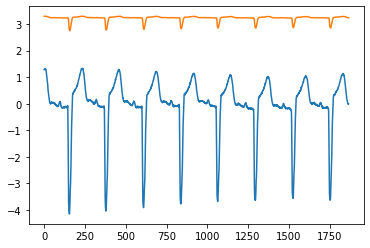

[[10626.69803126]]


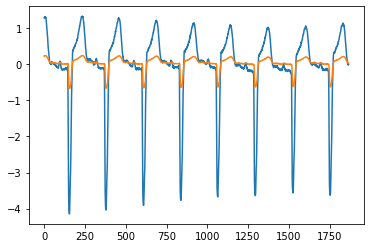

[[665.54680831]]


KeyboardInterrupt: 

In [77]:
#np.random.seed(150)
saeid = NN_Elman([10, 20, 1], 'sigmoid', eta_Wy= 0.001, eta_Wx= 0.001, eta_Ws= 0.001)
for epoch in range(20):
    #check epoch loss before train
    #and showing prediction
    pred = []
    loss = 0
    for record in range(X_train.shape[0]):
        pred.append(saeid.predict(X_train[record]))
        loss += ((Y_train[record] - pred[-1]) ** 2) / 2
    #changing pred list to a nump array
    pred = np.array(pred).reshape(-1)
    #showing real values and prediction in one plot
    plt.plot(Y_train)
    plt.plot(pred)
    plt.show()
    #reporting loss
    print(loss)
    
    #train phase
    #shuffling data before train
    temp_dataset = np.concatenate((X_train, Y_train), axis= 1).copy()
    np.random.shuffle(temp_dataset)
    X_shuffle = temp_dataset[:, :-1]
    Y_shuffle = temp_dataset[:, -1].reshape(-1, 1)
    #performing feed forward and back propagation for each record
    for record in range(X_shuffle.shape[0]):
        input_data, nets, states, outputs = saeid.feed_fwd(X_shuffle[record])
        saeid.back_pro(input_data, nets, states, outputs, Y_shuffle[record])

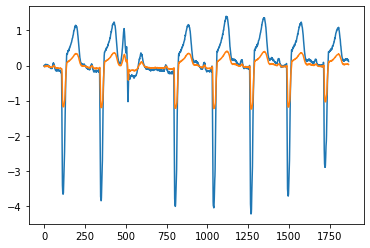

[[421.06570034]]


In [78]:
pred = []
loss = 0
for record in range(X_test.shape[0]):
    pred.append(saeid.predict(X_test[record]))
    loss += ((Y_test[record] - pred[-1]) ** 2) / 2
#changing pred list to a nump array
pred = np.array(pred).reshape(-1)
#showing real values and prediction in one plot
plt.plot(Y_test)
plt.plot(pred)
plt.show()
#reporting loss
print(loss)